# Проверка гипотез для увеличения выручки интернет-магазина

<a name="describe"></a>
## Описание задачи 

Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

*Данные:*
- 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort;
- результаты A/B теста (визиты);
- результаты A/B теста (заказы). 

*Задача 1.*
Необходимо приоритизировать гипотезы с использованием фрэймворков ICE и RICE.

*Задача 2.*
Необходимо проанализировать A/B-тест и принять решение:
 - Остановить тест, зафиксировать победу одной из групп. 
 - Остановить тест, зафиксировать отсутствие различий между группами. 
 - Продолжить тест.

<a name="contents"></a>
## Оглавление
- [Описание задачи.](#describe)

- [Оглавление.](#contents)

- [Изучение исходных данных.](#info)

- [Предобработка данных.](#preprocessing)

- [Приоритизация гипотез.](#hypotheses)


- [Анализ A/B-теста.](#A_B_test)

- [График кумулятивной выручки по группам.](#A_B_kum_revenue)
- [График кумулятивного среднего чека по группам.](#A_B_kum_check)
- [График относительного изменения кумулятивного среднего чека группы B к группе A.](#A_B_kum_check_otn)
- [График кумулятивной конверсии по группам.](#A_B_kum_conv)
- [График относительного изменения кумулятивной конверсии группы B к группе A.](#A_B_kum_conv_otn)
- [Точечный график количества заказов по пользователям.](#scatter_count_user)
- [Расчет 95-го и 99-го перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.](#per_order)
- [Точечный график стоимостей заказов.](#scatter_revenue_orders)
- [Расчет 95-го и 99-го перцентили стоимости заказов. Выбор границы для определения аномальных заказов.](#per_revenue)
- [Статистическая значимость различий в конверсии между группами по «сырым» данным.](#stat_conv_raw)
- [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.](#stat_check_raw)
- [Статистическая значимость различий в конверсии между группами по «очищенным» данным.](#stat_conv_filt)
- [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.](#stat_check_filt)
- [Результаты теста.](#result_test)

- [Общий вывод.](#conclusion)

<a name="info"></a>
## Изучение исходных данных. 

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import numpy as np

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# выгрузка dataframe и вывод на экран
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
orders = pd.read_csv('/datasets/orders.csv')

In [3]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [4]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
hypothesis.describe()

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Визуальное первичное ознакомление с данными выполнено.

<a name="preprocessing"></a>
## Предобработка данных

### Название столбцов в едином виде: низкий регистр и слитное написание

In [12]:
hypothesis.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')

In [13]:
#замена названий столбцов
hypothesis = hypothesis.rename(columns = {'Hypothesis': 'hypothesis',
                                          'Reach': 'reach',
                                          'Impact': 'impact',
                                          'Confidence': 'confidence',
                                          'Efforts': 'efforts'
                                         })

In [14]:
#проверяем
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### Datatime для столбцов с датами и временем

In [15]:
#Для дат устанавливаем формат datatime
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

### Проверка данных на пропуски, дубли и логику 

In [16]:
# Проверяем на пропуски
visitors.isnull().sum()

date        0
group       0
visitors    0
dtype: int64

In [17]:
# Проверяем на пропуски
orders.isnull().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [18]:
#ищем дубликаты
visitors.duplicated().sum()

0

In [19]:
#ищем дубликаты
orders.duplicated().sum()

0

In [20]:
#кол-во посетителей меньше нуля
visitors[visitors['visitors']<0]['visitors'].count()

0

In [21]:
#уникальные значения столбца group
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [22]:
#уникальные значения столбца group
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [23]:
# проверка данных на логику: наличие записей, когда revenue < 0.
orders[orders['revenue']<0]['revenue'].count()

0

In [24]:
# проверка на наличие одних покупателе в обоих группах и расчет их количества
orders_AB = orders.groupby('visitorId').agg({'revenue': 'sum', 'group':'count'}).reset_index()
orders_AB[orders_AB['group']>1].count()

visitorId    94
revenue      94
group        94
dtype: int64

In [25]:
#Доля выручки, которая поступила от клиентов, оказавшихся в обоих группах.
(orders_AB[orders_AB['group']>1]['revenue'].sum())/(orders['revenue'].sum())

0.20777342109326707

**Вывод**

*Хорошо:*
- Пропусков, дублей, аномалей нет.
- Дата приведена к типу datetime.
- Названия столбцов таблицы гипотез приведены к нижнему регистру.

*Плохо:*
- В таблице orders часть покупателей попали в обе группы.
- Доля выручки, которая поступила от клиентов, оказавшихся в обоих группах составляет около 0.2. Это много. Анализ таких данных может дать некорректные результаты.

Скорее всего возник технический сбой, который привел к тому, что одни и те же покупатели стали попадать в разные группы.
Его необходимо устранить и повторить эксперимент.

<a name="hypotheses"></a>
## Приоритизация гипотез.

In [26]:
#устанавливаем ширину столбца с названием гипотезы
pd.set_option('max_colwidth', -1)

In [27]:
#файл с гипотезами
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Применение фреймворка ICE

In [28]:
#Создаем столбцец ICE
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) /hypothesis['efforts']).round(2)
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Применение фреймворка RICE

In [29]:
#создаем столбец RICE и делаем сортировку по убыванию
hypothesis['RICE'] = (hypothesis['reach'] *hypothesis['impact']*hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [30]:
# Полное название 7-й гипотезы
hypothesis.loc[7,'hypothesis']

'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'

**Выводы**

- Мы применили два фреймворка для приоритезации гипотез: ICE и RICE.
- В результате применения ICE первую тройку сформировали следующие гипотезы (в порядке убывания): 8, 0, 7, 6, 2.
- Фреймворк RICE дал следующие результаты по ТОП-5 (в порядке убывания): 7, 2, 0, 6, 8.
- Состав ТОП-5 гипотез остается одинаковым при применении фреймворков ICE и RICE.

Различие в оценке объясняется наличием в RICE параметра охвата - Reach, который у седьмой гипотезы имеет максимальный бал (10), а у восьмой - очень низкий (1). У гипотезы номер два он равен 8, что поднимает ее вверх в фреймворке RICE.

Поскольку RICE является расширенной версией фреймворка ICE, учитывающий дополнительные факторы, то его оценку будем считать более соответствующей реальности. 

Приоритетная гипотеза для тестирования - №7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок."

<a name="A_B_test"></a>
## Анализ A/B-теста.

In [31]:
#Визиты
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [32]:
# Заказы
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<a name="A_B_kum_revenue"></a>
### График кумулятивной выручки по группам

In [33]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [34]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
        .agg({
        'date' : 'max', 
        'group' : 'max', 
        'transactionId' : pd.Series.nunique, 
        'visitorId' : pd.Series.nunique, 
        'revenue' : 'sum'
         }), axis=1).sort_values(by=['date','group'])
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [35]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
       lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
       .agg({
           'date' : 'max', 
           'group' : 'max', 
           'visitors' : 'sum'
            }), axis=1).sort_values(by=['date','group'])
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [36]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


In [37]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [38]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

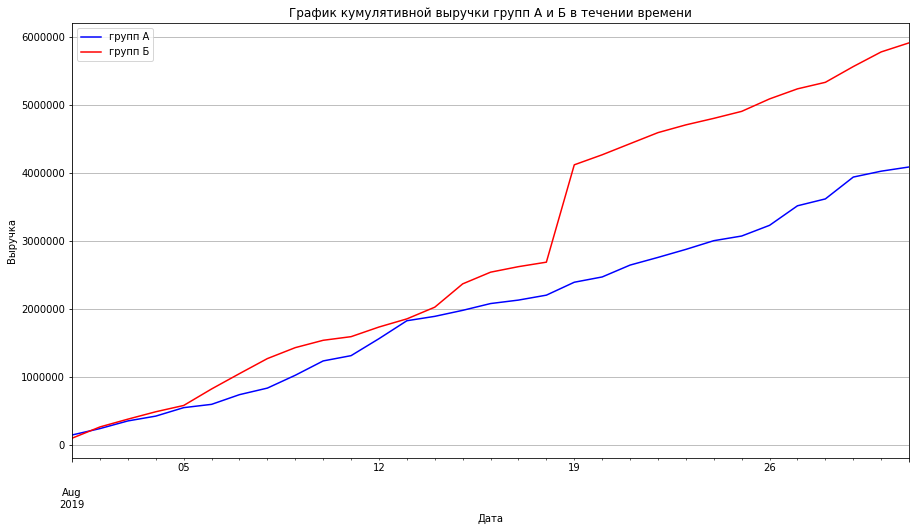

In [39]:
#график кумулятивной выручки групп А и Б в течении времени

ax=cumulativeRevenueA.plot(color='blue', alpha = 1, y= 'revenue', x='date', figsize=(15, 8), grid = True, label='групп A')

cumulativeRevenueB.plot(color='red', alpha = 1, y ='revenue', x='date', figsize=(15, 8), grid=True, ax=ax, label='групп Б')

plt.xlabel('Дата')

plt.ylabel('Выручка')

plt.title('График кумулятивной выручки групп А и Б в течении времени')

plt.show()

**Вывод**

- Выручка группы А и Б сначала была почти одинаковая( до 05.08.2019), далее плавно увеличилась и приняла почти параллельный группе А характер. Затем резко выросла 19.08, а после снова стала паралелльной линии группы А.

- Можно предположить, что в группе Б были несколько аномально дорогих покупок: 19.08 и несколько чуть менее дорогих между 05 и 12 августа.

- Необходимо проверить это предположение по анализу средних чеков.

<a name="A_B_kum_check"></a>
### График кумулятивного среднего чека по группам

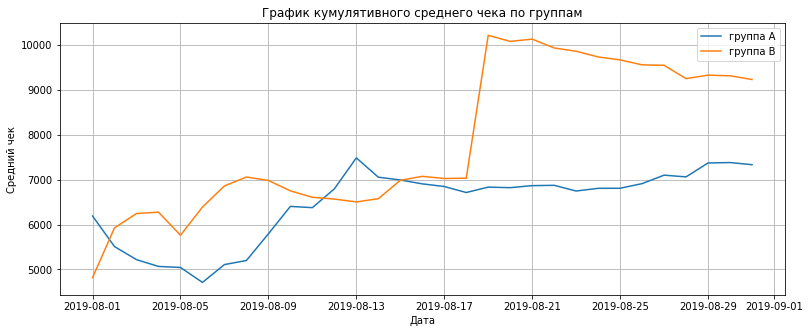

In [40]:
#Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
fig, ax = plt.subplots(figsize=(13, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='группа B')
plt.legend()
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('График кумулятивного среднего чека по группам')
plt.show()

**Вывод**

1. Кумулятивный средний чек у группы В имеет пики:
   - между 01 и 09 августа - два небольших;
   - большой 19.08.

2. В эти дни в группе Б были сделаны заказы с аномальной выручкой. 

<a name="A_B_kum_check_otn"></a>
### График относительного изменения кумулятивного среднего чека группы B к группе A

In [41]:
#Построим график относительного различия для среднего чека

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
                          cumulativeRevenueB, 
                          left_on='date', 
                          right_on='date', 
                          how='left', 
                          suffixes=['A', 'B'])

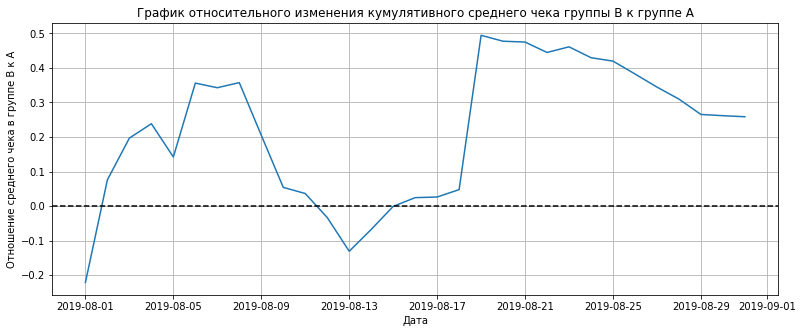

In [42]:
# cтроим отношение средних чеков
plt.subplots(figsize=(13, 5))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека в группе B к A')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

**Вывод**

График имеет резкие пики - скорее всего этого крупные заказы в группе Б.

<a name="A_B_kum_conv"></a>
### График кумулятивной конверсии по группам

In [43]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [44]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

In [45]:
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

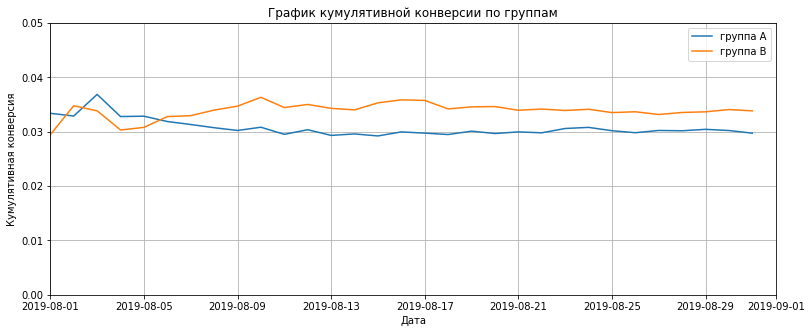

In [46]:
# строим графики
fig, ax = plt.subplots(figsize=(13, 5))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='группа B')

plt.legend()
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.title('График кумулятивной конверсии по группам')

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])

plt.show()

**Вывод**

1. После 19.08.2019 график становится симметричным - приблизительно относительно значения 0.033.
2. На участке  до 05.08.2019 графики групп А и B вели себя аналогично. Однако после этого график группы А пошел вниз, а группы B вверх.
3. Начиная с 10.08.2019 оба графика выравниваются друг относительно друга и идут параллельно. Группа B имеет профит 0.005.

<a name="A_B_kum_conv_otn"></a>
### График относительного изменения кумулятивной конверсии группы B к группе A

In [47]:
#объединим таблицы
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                              .merge(cumulativeDataB[['date','conversion']], 
                               left_on='date', 
                               right_on='date', 
                               how='left', 
                               suffixes=['A', 'B']))

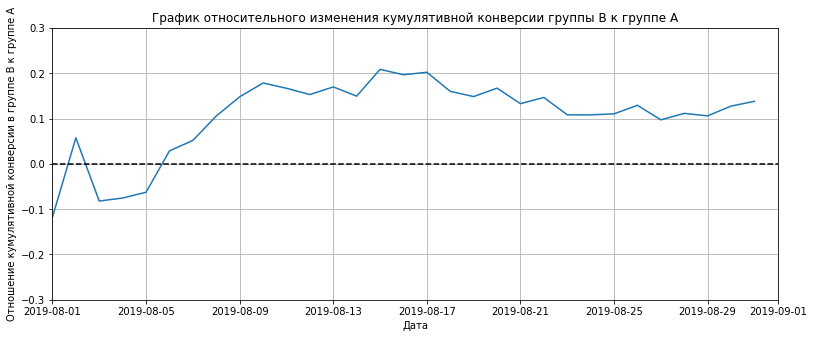

In [48]:
# строим график
plt.subplots(figsize=(13, 5))

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивной конверсии в группе B к группе А')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')

#ось
plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.3, 0.3])

plt.show()

**Вывод**

- На начальном участке показатели конверсии групп А и Б колебались.
- Однако после 09.08.2019 группа Б значительно оторвалась от группы А.
- Затем наблюдались эпизодические скачки и падения у группы Б, но в целом можно сказать, что ее показатели конверсии стабилизировались и они превышают значения в группе А.

Для корректной оценки необходимо проанализировать аномалии.

<a name="scatter_count_user"></a>
### Точечный график количества заказов по пользователям

In [49]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [50]:
#удаляем столбцы, группируем по пользователю, считаем уникальные покупки
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

In [51]:
#переименовываем столбцы и делаем сортировку по убыванию
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head()

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


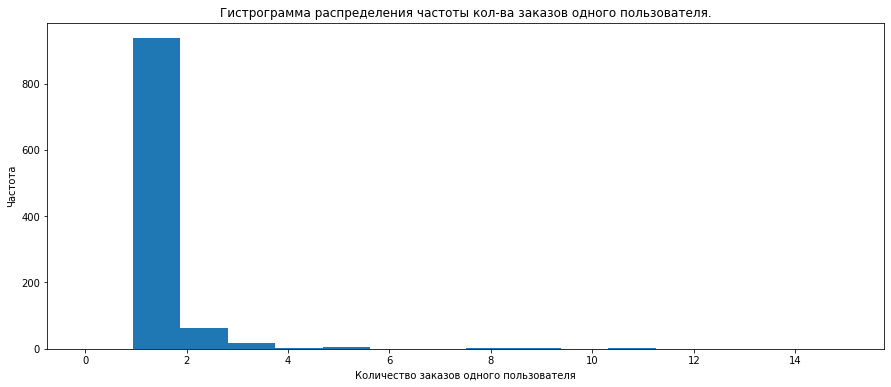

In [52]:
#Посмотрим распределение:
ordersByUsers['orders'].plot(kind='hist', bins=16, figsize=(15, 6), range=(0, 15))
plt.xlabel('Количество заказов одного пользователя')
plt.ylabel('Частота')
plt.title('Гистрограмма распределения частоты кол-ва заказов одного пользователя.')
plt.show()

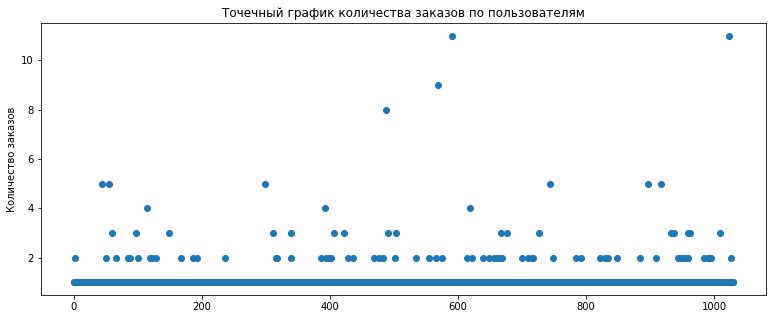

In [53]:
#точечный график
plt.subplots(figsize=(13, 5))
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов')


x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

plt.show()

**Вывод**

Есть пользователи с количеством заказов более 4 шт. Необходимо посмотреть 95 и 99 перцентели кол-ва заказов на пользователя.

<a name="per_order"></a>
### Расчет 95-го и 99-го перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

In [54]:
#Посчитаем выборочные перцентили количества заказов на одного пользователя:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Вывод**

Менее 5% процентов пользователей сделали более 2 заказов. Выбираем границу пользователей с аномальным количеством заказов >2.

<a name="scatter_revenue_orders"></a>
### Точечный график стоимостей заказов

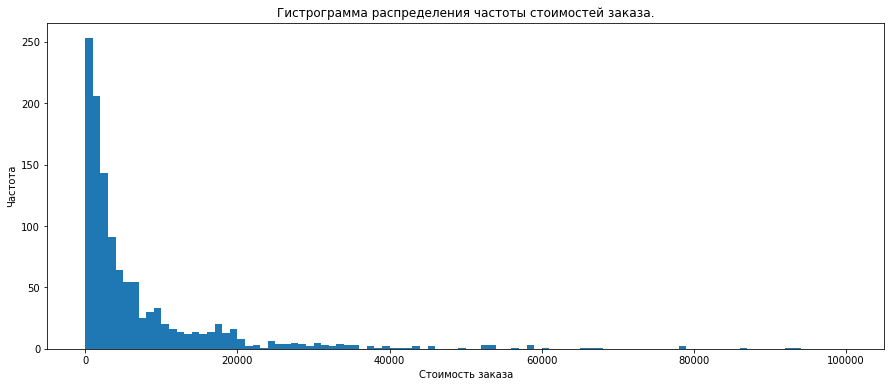

In [55]:
#Посмотрим распределение:
orders['revenue'].plot(kind='hist', bins=100, figsize=(15, 6), range=(0, 100000))
plt.xlabel('Стоимость заказа')
plt.ylabel('Частота')
plt.title('Гистрограмма распределения частоты стоимостей заказа.')
plt.show()

- На гистрограмме есть аномальные заказы.
- Изучим их дополнительно на scatter график.

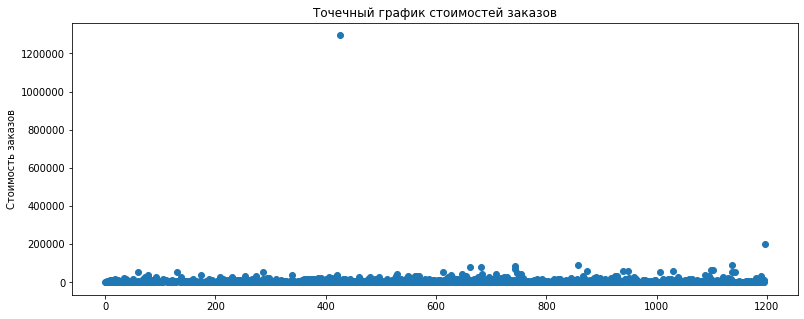

In [56]:
#skatter график стоимости заказов
plt.subplots(figsize=(13, 5))
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказов')

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.show()

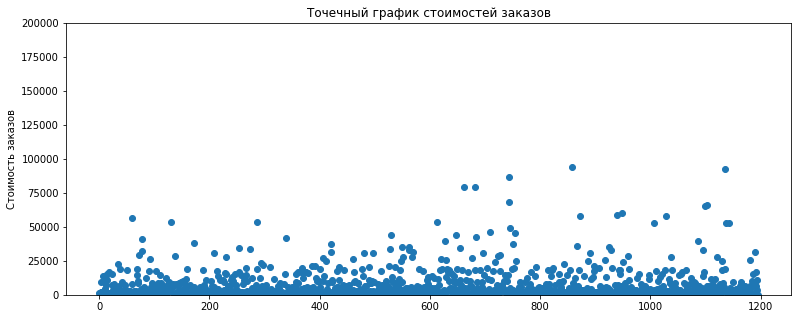

In [57]:
# Рассмотрим более детально часть графика меньше 200000
#skatter график стоимости заказов
plt.subplots(figsize=(13, 5))
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказов')
plt.ylim (0, 200000)
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.show()

**Вывод**

Как минимум 2 аномально очень больших заказа и некоторое количество заказов, имеющих стоимость выше чем у большинства. 

Необходимо посчитать 95 и 99 перцентили стоимости заказов для более точной оценки.

<a name="per_revenue"></a>
### Расчет 95-го и 99-го перцентилей стоимости заказов. Выбор границы для определения аномальных заказов.

In [58]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод** 

Менее 5% заказов имеют стоимость более 28000 руб. Установим эту цифру, как границу области заказов с аномальной ценой.

<a name="stat_conv_raw"></a>
### Статистическая значимость различий в конверсии между группами по «сырым» данным

Формулировка нулевой и альтернативных гипотез:
- H0 - нулевая гипотеза: конверсия в группе A равна конверсии в группе B. Формируем ее исходя из того, что она должна иметь знак равенства в формулировке.
- H1 - альтернативная гипотеза: конверсия в группе A отличается от конверсии в группе B. Она должна быть противоположной по смыслу нулевой гипотезе.

- для проверки гипотез используем критерий порогового уровня статистической значимости равный 5%, как один из общепринятых критериев оценки достоверности гипотез.

In [59]:
#пользователи относящиеся к группе А и нужные столбцы
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsADaily.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [60]:
#кумулятивная сумма кол-ва пользователей в группе A и переименование столбцов
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [61]:
#пользователи относящиеся к группе B и нужные столбцы с новыми названиями
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBDaily.head()

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [62]:
#кумулятивная сумма кол-ва пользователей в группе B и переименование столбцов
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [63]:
#заказы в группе А, сгруппированные по дате, кол-во уникальных заказов и сумма по выручке
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

#новые названия столбцов
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily.head()

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [64]:
#кумулятивная сумма в группе A и переименование столбцов

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [65]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [66]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]
ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [67]:
#объединяем таблицы
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [68]:
#Создадим переменные для пользователей, которые заказывали хотя бы 1 раз и укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [69]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [70]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# У пользователей без заказов будут нули 
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [71]:
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [72]:
# проверка  по критерию Манна-Уитни:
stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1].round(4)

0.0168

In [73]:
# относительный прирост конверсии группы B:
(sampleB.mean() / sampleA.mean() - 1).round(4)

0.1381

**Вывод**

- По "сырым" данным p-value = 0.0168, что меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем, т.е. есть статистические различия в конверсии по сырым данным между группам  A и B.
- Относительный прирост конверсии в группе составляет около 14 %.

<a name="stat_check_raw"></a>
### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Формулировка нулевой и альтернативных гипотез:
- H0 - нулевая гипотеза: средний чек в группе A равен среднему чеку в группе B. Формируем ее исходя из того, что она должна иметь знак равенства в формулировке.
- H1 - альтернативная гипотеза: средний чек в группе A отличается от среднего чека в группе B. Она должна быть противоположной по смыслу нулевой гипотезе.

- для проверки гипотез используем критерий порогового уровня статистической значимости равный 5%, как один из общепринятых критериев оценки достоверности гипотез.

In [74]:
#статистическая значимость различий в среднем чеке между группами А и Б
(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                    orders[orders['group']=='B']['revenue'], 
                    alternative = 'two-sided')[1]).round(4)

0.7293

In [75]:
# относительные различия в среднем чеке между группами А и Б
(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1).round(4)

0.2587

**Вывод**

- По "сырым" данным p-value = 0.7293, что больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем, т.е. средний чек по сырым в группах А и Б одинаковый.
- Относительное различие в среднем чеке между группой Б и группой А составляет около 26 %, т.е. у группы Б он больше.

<a name="stat_conv_filt"></a>
### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000 рублей. 

Формулировка нулевой и альтернативных гипотез:
- H0 - нулевая гипотеза: конверсия в группе A равна конверсии в группе B. Формируем ее исходя из того, что она должна иметь знак равенства в формулировке.
- H1 - альтернативная гипотеза: конверсия в группе A отличается от конверсии в группе B. Она должна быть противоположной по смыслу нулевой гипотезе.

- для проверки гипотез используем критерий порогового уровня статистической значимости равный 5%, как один из общепринятых критериев оценки достоверности гипотез.

In [76]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [77]:
#Сделаем срез пользователей с числом заказов больше 2
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
) 

In [78]:
#Сделаем срез пользователей совершивших заказы дороже 28 000
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

In [79]:
#Объединим их в таблице abnormalUsers
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head()

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64

In [80]:
#Кол-во аномальных пользователей
abnormalUsers.shape

(74,)

In [81]:
#подготовим выборки количества заказов по пользователям по группам:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [82]:
# проверка  по критерию Манна-Уитни:
(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]).round(4)

0.013

In [83]:
# относительный прирост конверсии группы B по фильтрованным данным:
(sampleBFiltered.mean()/sampleAFiltered.mean()-1).round(4)

0.1727

**Вывод**

- По "очищенным" данным p-value = 0.013, что меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем, т.е. есть статистические различия в конверсии по очищенным данным между группам  A и B.
- Относительный прирост конверсии в группе составляет около 17 %.

Таким образом, очистка от аномальных значений подтвердила результаты полученные по "сырым" данным, глубже обозначив тенденцию.


<a name="stat_check_filt"></a>
### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Формулировка нулевой и альтернативных гипотез:
- H0 - нулевая гипотеза: средний чек в группе A равен среднему чеку в группе B. Формируем ее исходя из того, что она должна иметь знак равенства в формулировке.
- H1 - альтернативная гипотеза: средний чек в группе A отличается от среднего чека в группе B. Она должна быть противоположной по смыслу нулевой гипотезе.

- для проверки гипотез используем критерий порогового уровня статистической значимости равный 5%, как один из общепринятых критериев оценки достоверности гипотез.

In [84]:
sampleAFiltered_average_check = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
sampleAFiltered_average_check.head()

,transactionId,visitorId,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
10,3649131742,879864040,2019-08-15,4008,A
12,2809384911,3213223594,2019-08-15,7370,A


In [85]:
sampleBFiltered_average_check = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
sampleBFiltered_average_check.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [86]:
#статистическая значимость различий в среднем чеке между группами А и Б по очищенным данным
(stats.mannwhitneyu(sampleAFiltered_average_check['revenue'],
                    sampleBFiltered_average_check['revenue'], 
                    alternative = 'two-sided')[1]).round(4)

0.7385

**Вывод**

- По "очищенным" данным p-value = 0.7385, что больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем, т.е. средний чек по сырым в группах А и Б одинаковый.
- Относительное различие в среднем чеке между группой Б и группой А составляет около 2%, т.е. у группы А он больше.

Отсутствие аномалий почти не повлияло на статистическую значимость гипотез.
Однако сильно изменило относительное различие среднего чека между группами. При расчете с "сырыми" данным оно был 26 % в пользу группы Б, а после "очистки" оно изменилось на 2% в пользу группы А.

<a name="result_test"></a>
### Результаты теста

**Вывод**

- Есть статистически значимое различие по конверсии между группами A и B  по «сырым» и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A, при этом динамика стабилизировалась.

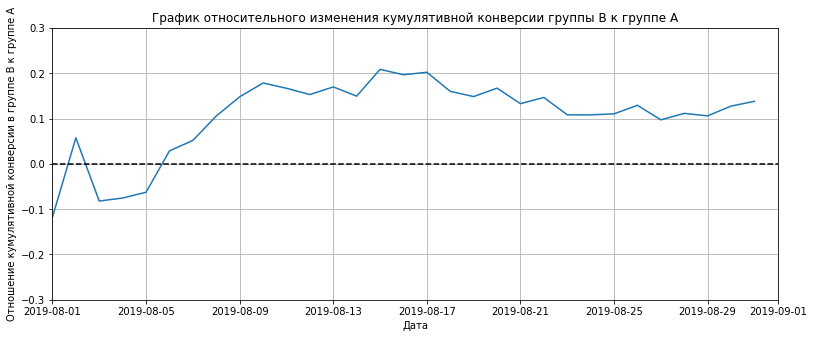

In [87]:
plt.subplots(figsize=(13, 5))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивной конверсии в группе B к группе А')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')

#ось
plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.3, 0.3])

plt.show()

- График изменения различия среднего чека говорит о том, что результаты группы B лучше, чем результаты группы А. Но, хотя значения на конечном участке находятся в положительной зоне, график еще не стабилизировался. 

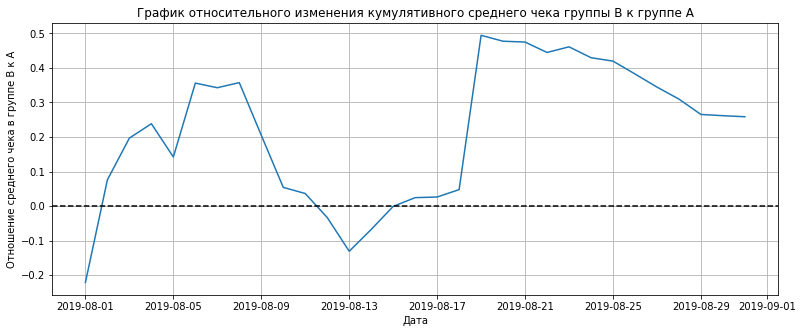

In [88]:
# cтроим отношение средних чеков
plt.subplots(figsize=(13, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека в группе B к A')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

**Решение по результатам теста**

Остановить тест. Группа Б - победитель. 

По результатам статистических тестов у группы Б показатели по конверсии лучше на 14-17%, чем у группы А. При этом исходя из графика кумулятивной конверсии по группам динамика стабилизировалась.
Статистические тесты не выявили разницы с среднем чеке у групп А и Б и относительные различия в среднем чеке между группами А и Б по "очищенным" данным составляют - 2% в пользу группы А. 

Т.е. можно говорить о том, что средний чек в группе остался такой же, как у группы А, но при этом конверсия выросла на 14-17 %.


<a name="conclusion"></a>
## Общие выводы.

1. В первой части исследования мы применили для приоритезации гипотез по увеличению выручки интернет-магазина фреймворки ICE и RICE. В результате был получен одинаковый по составу ТОП-5 гипотез для обоих методов. Поскольку RICE является расширенной версией фреймворка ICE, учитывающий дополнительный фактор, то приняли оценку согласно этому фреймворку. Таким образом, приоритетная гипотеза для тестирования - №7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок."

2. Во второй части исследования мы проанализировали результаты A/B теста с целью установить различие(или его отсутствие) в конверсии и среднем чеке у покупателей из группы A и группы B. В результате проведенных статистических тестов по методу Манна-Уитни установили, что у группы B показатели по конверсии лучше на 14-17%, чем у группы А. При этом разницы в среднем чеке у групп А и B не выявлено.

**По результатам А/B теста было принято решение тест остановить и признать победителем группу B.**

3. Несмотря на то, что было принято основное решение о приостановке теста и признании победителем группы B, рекомендуем данный эксперимент аннулировать. И реализовать следующий порядок действий: устранить технические проблемы (которые привели к тому, что многие покупатели оказались одновременно в двух группах), выполнить А/А тест для проверки соблюдения условий корректного выполнения нового А/B теста и после этого повторить А/B тест. 